In [1]:
from keras.layers import Dense, Input, Concatenate, Conv1D, Flatten, MaxPool2D
from keras.models import Model

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import TensorBoard

In [2]:
import meshio
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Mesh import from Gmsh to Fenics

In [3]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    out_mesh = meshio.Mesh(points=mesh.points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    if prune_z:
        out_mesh.prune_z_0()
    return out_mesh

In [4]:
def gmsh_to_xdmf_2D(mesh):
    line_mesh = create_mesh(mesh, "line", prune_z=True)
    meshio.write("mesh/facets_2d.xdmf", line_mesh)

    triangle_mesh = create_mesh(mesh, "triangle", prune_z=True)
    meshio.write("mesh/mesh_2d.xdmf", triangle_mesh)

In [5]:
MESH_NAME = "Plate_with_hole"
msh = meshio.read( "mesh/" + MESH_NAME + ".msh" )
gmsh_to_xdmf_2D(msh)
mesh_unsplited = Mesh()

with XDMFFile("mesh/mesh_2d.xdmf") as infile:
    infile.read(mesh_unsplited)
mvc = MeshValueCollection("size_t", mesh_unsplited, 1)

x_test = mesh_unsplited.coordinates()[:, 0] 
y_test = mesh_unsplited.coordinates()[:, 1]


MESH_NAME = "Plate_with_hole_small_for_test"
msh = meshio.read( "mesh/" + MESH_NAME + ".msh" )
gmsh_to_xdmf_2D(msh)
mesh_test_2 = Mesh()

with XDMFFile("mesh/mesh_2d.xdmf") as infile:
    infile.read(mesh_test_2)
mvc = MeshValueCollection("size_t", mesh_test_2, 1)

x_test_2 = mesh_test_2.coordinates()[:, 0] 
y_test_2 = mesh_test_2.coordinates()[:, 1]


MESH_NAME = "Plate_with_hole_splited"
msh = meshio.read( "mesh/" + MESH_NAME + ".msh" )
gmsh_to_xdmf_2D(msh)
mesh = Mesh()

with XDMFFile("mesh/mesh_2d.xdmf") as infile:
    infile.read(mesh)
mvc = MeshValueCollection("size_t", mesh, 1)

with XDMFFile("mesh/facets_2d.xdmf") as infile:
    infile.read(mvc)
fd = MeshFunction("size_t", mesh, mvc)
ds = Measure('ds', domain=mesh, subdomain_data=fd)

x_train = mesh.coordinates()[:, 0] 
y_train = mesh.coordinates()[:, 1]


msh

<meshio mesh object>
  Number of points: 4050
  Number of cells:
    line: 268
    triangle: 7832
  Cell data: gmsh:physical, gmsh:geometrical

In [6]:
print('About meshes\nMesh unslpited (original):', mesh_unsplited.num_vertices())
print('Mesh test:', mesh_test_2.num_vertices())
print('Mesh splited:', mesh.num_vertices())

About meshes
Mesh unslpited (original): 1046
Mesh test: 1117
Mesh splited: 4050


## Getting the FEM-solution

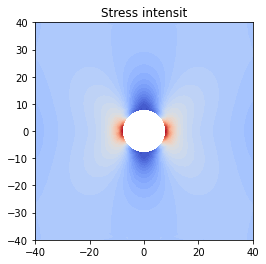

In [17]:
from ufl import nabla_grad
from ufl import nabla_div

E = 25 # [MPa]
nu = 0.2
P = 50 # [MPa
mu_ = E/(2*(1+nu))
lambda_ = E*nu/((1+nu)*(1-2*nu))

V = VectorFunctionSpace(mesh, 'P', 1)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu_*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
n = FacetNormal(mesh)

sigXXN = Constant((-50, 0, 0))
sigYYN = Constant((0, -40, 0))
sigma_inf = as_tensor([ [Constant((-50)), 0],
                        [0, Constant((-40))] ])
sigma_hydrostat = as_tensor([ [Constant((-P)), 0],
                        [0, Constant((-P))] ])

a = inner(sigma(u), epsilon(v))*dx
L = dot( dot(sigma_inf, n), v)*ds(2) + dot( dot(sigma_hydrostat, n), v)*ds(1) 

# Compute solution
u = Function(V)
solve(a == L, u)

# Plot solution
# plot(u, title='Displacement', mode='displacement')

# # Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))

V = FunctionSpace(mesh, 'P', 1)
V_unsplited = FunctionSpace(mesh_unsplited, 'P', 1)
V_test_2 = FunctionSpace(mesh_test_2, 'P', 1)

von_Mises = project(von_Mises, V)
fe_sigma_xx = project(sigma(u)[0,0], V)
fe_sigma_xy = project(sigma(u)[0,1], V)
fe_sigma_yy = project(sigma(u)[1,1], V)

plot(von_Mises, title='Stress intensit', cmap=cm.coolwarm)
plot(fe_sigma_xx, title='Stress intensit', cmap=cm.coolwarm)
plot(fe_sigma_yy, title='Stress intensit', cmap=cm.coolwarm)

# test_func = Function(V_unsplited)
# Ve_quad = VectorElement("Quadrature", mesh.ufl_cell(), degree=1, dim=3, quad_scheme='default')
# V_quad = FunctionSpace(mesh, Ve_quad)

# Vse = FiniteElement("Quadrature", mesh.ufl_cell(), degree=3, quad_scheme='default')
# Vs = FunctionSpace(mesh, Vse)
# test_stress = project(u[0], Vs, form_compiler_parameters={"quadrature_degree":3})
# stresses = project( as_vector([sigma(u)[0,0], sigma(u)[1,1], sigma(u)[0,1]]), V_quad )
# stresses = project( as_vector([u[0], u[1], u[1]]), V_quad )
# # Compute magnitude of displacement
# u_magnitude = sqrt(dot(u, u))
# u_magnitude = project(u_magnitude, V)
# plot(u_magnitude, 'Displacement magnitude')
# print('min/max u:',
#       u_magnitude.vector().get_local().min(),
#       u_magnitude.vector().get_local().max())

# # Save solution to file in VTK format
File('elasticity/displacement.pvd') << u
File('elasticity/von_mises.pvd') << von_Mises
File('elasticity/stress_xx.pvd') << fe_sigma_xx
# File('elasticity/magnitude.pvd') << u_magnitude


## Dataset preparation

In [18]:
# ux, uy = u.split(deepcopy=True)
# ux.vector().get_local().shape

In [19]:
def getValuesOnUnsplitedMesh(x_splited, y_splited, x_unsplited, y_unsplited, field_splited):
    N_us = x_unsplited.shape[0]
    N_s = x_splited.shape[0]
    field_unsplited = np.zeros((N_us))
    for i in np.arange(N_us):
        for j in np.arange(N_s):
            if (x_unsplited[i] == x_splited[j]) and (y_unsplited[i] == y_splited[j]):
                field_unsplited[i] = field_splited[j]
                break
    return field_unsplited

def convertNPArrayFromNodesToDOFs(x_nodes, y_nodes, x_dofs, y_dofs, array_nodes):
    assert x_nodes.shape[0] == x_dofs.shape[0], "DOFs and nodes aren't compatible! It's necessary to make another algorithm." 
    N = x_nodes.shape[0]
    array_dofs = np.zeros((N))
    for i in np.arange(N): 
        for j in np.arange(N):
            if (x_nodes[j] == x_dofs[i]) and (y_nodes[j] == y_dofs[i]):
                array_dofs[i] = array_nodes[j]
                break
    return array_dofs


def convertNPArrayInDOFsToFieldFunction(function_space, array_dofs):
    # assert x_nodes.shape[0] != x_dofs.shape[0], "DOFs and nodes aren't compatible! It's necessary to make another algorithm." 
    field = Function(function_space)
    field.vector()[:] = array_dofs
    return field

def convertNPArrayInNodesToFieldFunction(x_train, y_train, x_dofs, y_dofs, array_nodes, function_space):
    array_dofs = convertNPArrayFromNodesToDOFs(x_train, y_train, x_dofs, y_dofs, array_nodes)
    return convertNPArrayInDOFsToFieldFunction(function_space, array_dofs)

* Train - is the data from splited (dense) mesh
* Test - is the data from original unsplited (coarse) mesh, which nodes are coincided with the previous one

In [20]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1,1)).reshape(-1)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1)
xy_train_scaled = np.transpose(np.array( [x_train_scaled, y_train_scaled] ))

sXX_train = fe_sigma_xx.compute_vertex_values()
sXY_train = fe_sigma_xy.compute_vertex_values()
sYY_train = fe_sigma_yy.compute_vertex_values()

sXX_train_scaled = scaler.fit_transform(sXX_train.reshape(-1,1)).reshape(-1)
sXY_train_scaled = scaler.fit_transform(sXY_train.reshape(-1,1)).reshape(-1)
sYY_train_scaled = scaler.fit_transform(sYY_train.reshape(-1,1)).reshape(-1)

sXX_XY_YY_train_scaled = np.transpose(np.array( [sXX_train_scaled, sXY_train_scaled, sYY_train_scaled] ))

x_test_scaled = scaler.fit_transform(x_test.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler.fit_transform(y_test.reshape(-1,1)).reshape(-1)
xy_test_scaled = np.transpose(np.array( [x_test_scaled, y_test_scaled] ))

sXX_test_scaled = getValuesOnUnsplitedMesh(x_train, y_train, x_test, y_test, sXX_train_scaled)
sXY_test_scaled = getValuesOnUnsplitedMesh(x_train, y_train, x_test, y_test, sXY_train_scaled)
sYY_test_scaled = getValuesOnUnsplitedMesh(x_train, y_train, x_test, y_test, sYY_train_scaled)

### Project the solution from the splited mesh onto mesh_test_2
* Test 2 - is the data for coarse mesh similar to unsplited mesh (the nodes are not coincided)

In [21]:
x_test_2_scaled = scaler.fit_transform(x_test_2.reshape(-1,1)).reshape(-1)
y_test_2_scaled = scaler.fit_transform(y_test_2.reshape(-1,1)).reshape(-1)
xy_test_2_scaled = np.transpose(np.array( [x_test_2_scaled, y_test_2_scaled] ))

sXX_test_2 = np.zeros(mesh_test_2.coordinates().shape[0])
sYY_test_2 = np.zeros(mesh_test_2.coordinates().shape[0])
sXY_test_2 = np.zeros(mesh_test_2.coordinates().shape[0])
for i in np.arange(sXX_test_2.shape[0]):
    sXX_test_2[i] = fe_sigma_xx(x_test_2[i], y_test_2[i])
    sYY_test_2[i] = fe_sigma_yy(x_test_2[i], y_test_2[i])
    sXY_test_2[i] = fe_sigma_xy(x_test_2[i], y_test_2[i])

sXX_test_2_scaled = scaler.fit_transform(sXX_test_2.reshape(-1,1)).reshape(-1)
sYY_test_2_scaled = scaler.fit_transform(sYY_test_2.reshape(-1,1)).reshape(-1)
sXY_test_2_scaled = scaler.fit_transform(sXY_test_2.reshape(-1,1)).reshape(-1)

In [58]:
input_xy = Input(shape = (2))
layer = Dense(units = 8, activation='relu')(input_xy)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 8, activation='relu')(layer)

output_u = Dense(units=1, activation='relu')(layer)

model_xy_input = Model(input_xy, output_u)
model_xy_input.summary()

model_xy_input.compile(optimizer = "adam", loss='mean_absolute_error')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_66 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_67 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_68 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_69 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_70 (Dense)             (None, 64)                2112

In [60]:
history = model_xy_input.fit(xy_train_scaled, sXX_train_scaled, epochs = 120)

Epoch 1/120
127/127 [==============================] - 6s 26ms/step - loss: 0.2819
Epoch 2/120
127/127 [==============================] - 3s 25ms/step - loss: 0.0392
Epoch 3/120
127/127 [==============================] - 3s 26ms/step - loss: 0.0387
Epoch 4/120
127/127 [==============================] - 4s 28ms/step - loss: 0.0406
Epoch 5/120
127/127 [==============================] - 3s 24ms/step - loss: 0.0383
Epoch 6/120
127/127 [==============================] - 3s 23ms/step - loss: 0.0378
Epoch 7/120
127/127 [==============================] - 3s 26ms/step - loss: 0.0373
Epoch 8/120
127/127 [==============================] - 3s 21ms/step - loss: 0.0348
Epoch 9/120
127/127 [==============================] - 3s 23ms/step - loss: 0.0329
Epoch 10/120
127/127 [==============================] - 4s 28ms/step - loss: 0.0288
Epoch 11/120
127/127 [==============================] - 4s 31ms/step - loss: 0.0290
Epoch 12/120
127/127 [==============================] - 3s 26ms/step - loss: 0.0289
E

In [32]:
# model.save('model_input_one_list.h5')

In [47]:
input_xy = Input(shape = (2,))
layer = Dense(units = 8, activation='relu')(input_xy)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
# layer = Dense(units = 128, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 8, activation='relu')(layer)

output_stresses = Dense(units=3, activation='relu')(layer)

model_input_2_output_3 = Model(input_xy, output_stresses)
model_input_2_output_3.summary()
model_input_2_output_3.compile(optimizer = "adam", loss='mean_absolute_error')

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_124 (Dense)            (None, 8)                 24        
_________________________________________________________________
dense_125 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_126 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_127 (Dense)            (None, 32)                544       
_________________________________________________________________
dense_128 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_129 (Dense)            (None, 64)                2112

In [48]:
tensorboard_callback = TensorBoard(log_dir='./Logs/adam')
history = model_input_2_output_3.fit(xy_train_scaled, sXX_XY_YY_train_scaled, epochs = 200, callbacks=[tensorboard_callback])

Epoch 1/200
127/127 [==============================] - 5s 21ms/step - loss: 0.3011
Epoch 2/200
127/127 [==============================] - 2s 17ms/step - loss: 0.2033
Epoch 3/200
127/127 [==============================] - 2s 16ms/step - loss: 0.2030
Epoch 4/200
127/127 [==============================] - 3s 23ms/step - loss: 0.2007
Epoch 5/200
127/127 [==============================] - 4s 33ms/step - loss: 0.2018
Epoch 6/200
127/127 [==============================] - 4s 28ms/step - loss: 0.2003
Epoch 7/200
127/127 [==============================] - 3s 26ms/step - loss: 0.2004
Epoch 8/200
127/127 [==============================] - 3s 20ms/step - loss: 0.1983
Epoch 9/200
127/127 [==============================] - 4s 28ms/step - loss: 0.1971
Epoch 10/200
127/127 [==============================] - 3s 25ms/step - loss: 0.1964
Epoch 11/200
127/127 [==============================] - 2s 17ms/step - loss: 0.1955
Epoch 12/200
127/127 [==============================] - 2s 17ms/step - loss: 0.1946
E

In [49]:
model_input_2_output_3.save('model_input_2_output_3_v2.h5')

In [ ]:
# tensorboard --logdir

### Fields preparation for data visualisation

In [50]:
x_dofs = V.tabulate_dof_coordinates()[:,0]
y_dofs = V.tabulate_dof_coordinates()[:,1]
x_dofs_scaled = scaler.fit_transform(x_dofs.reshape(-1,1))
y_dofs_scaled = scaler.fit_transform(y_dofs.reshape(-1,1))

fe_sigma_xx_scaled = convertNPArrayInNodesToFieldFunction(x_train, y_train, x_dofs, y_dofs, sXX_train_scaled, V)
fe_sigma_xy_scaled = convertNPArrayInNodesToFieldFunction(x_train, y_train, x_dofs, y_dofs, sXY_train_scaled, V)
fe_sigma_yy_scaled = convertNPArrayInNodesToFieldFunction(x_train, y_train, x_dofs, y_dofs, sYY_train_scaled, V)


In [52]:
predicted_stresses = model_input_2_output_3.predict(xy_test_scaled)
sXX_predict_scaled = predicted_stresses[:,0]
sXY_predict_scaled = predicted_stresses[:,1]
sYY_predict_scaled = predicted_stresses[:,2]

x_dofs_unsplited = V_unsplited.tabulate_dof_coordinates()[:,0]
y_dofs_unsplited = V_unsplited.tabulate_dof_coordinates()[:,1]
x_dofs_unsplited_scaled = scaler.fit_transform(x_dofs_unsplited.reshape(-1,1))
y_dofs_unsplited_scaled = scaler.fit_transform(y_dofs_unsplited.reshape(-1,1))

fe_sigma_xx_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sXX_test_scaled, V_unsplited)
fe_sigma_xy_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sXY_test_scaled, V_unsplited)
fe_sigma_yy_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sYY_test_scaled, V_unsplited)

fe_sigma_xx_predicted_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sXX_predict_scaled, V_unsplited)
fe_sigma_xy_predicted_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sXY_predict_scaled, V_unsplited)
fe_sigma_yy_predicted_unsplited_scaled = convertNPArrayInNodesToFieldFunction(x_test, y_test, x_dofs_unsplited, y_dofs_unsplited, sYY_predict_scaled, V_unsplited)

In [53]:
predicted_stresses_test_2 = model_input_2_output_3.predict(xy_test_2_scaled)
sXX_predict_test_2_scaled = predicted_stresses_test_2[:,0]
sXY_predict_test_2_scaled = predicted_stresses_test_2[:,1]
sYY_predict_test_2_scaled = predicted_stresses_test_2[:,2]

x_dofs_test_2 = V_test_2.tabulate_dof_coordinates()[:,0]
y_dofs_test_2 = V_test_2.tabulate_dof_coordinates()[:,1]
x_dofs_test_2_scaled = scaler.fit_transform(x_dofs_test_2.reshape(-1,1))
y_dofs_test_2_scaled = scaler.fit_transform(y_dofs_test_2.reshape(-1,1))

fe_sigma_xx_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sXX_test_2_scaled, V_test_2)
fe_sigma_yy_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sYY_test_2_scaled, V_test_2)
fe_sigma_xy_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sXY_test_2_scaled, V_test_2)

fe_sigma_xx_predicted_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sXX_predict_test_2_scaled, V_test_2)
fe_sigma_yy_predicted_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sYY_predict_test_2_scaled, V_test_2)
fe_sigma_xy_predicted_test_2_scaled = convertNPArrayInNodesToFieldFunction(x_test_2, y_test_2, x_dofs_test_2, y_dofs_test_2, sXY_predict_test_2_scaled, V_test_2)

## 2D Plots

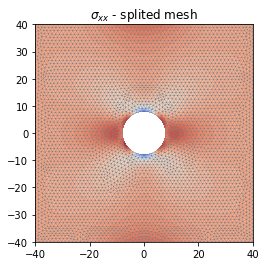

In [95]:
plot(fe_sigma_xx_scaled, title=r'$\sigma_{xx}$' + " - splited mesh", cmap=cm.coolwarm)
plot(mesh, linewidth=0.3)
plt.savefig('sxx_1.pdf', bbox_inches = 'tight')

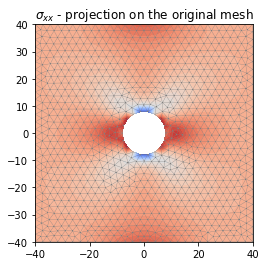

In [96]:
plot(fe_sigma_xx_unsplited_scaled, title=r'$\sigma_{xx}$' + " - projection on the original mesh", cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('sxx_2.pdf', bbox_inches = 'tight')

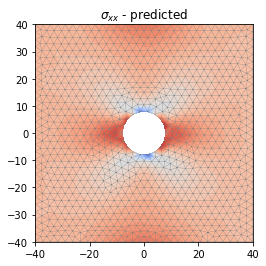

In [97]:
plot(fe_sigma_xx_predicted_unsplited_scaled, title=r'$\sigma_{xx}$' + " - predicted", cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('sxx_p.pdf', bbox_inches = 'tight')

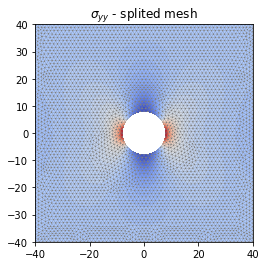

In [98]:
plot(fe_sigma_yy_scaled, title=r'$\sigma_{yy}$' + " - splited mesh", cmap=cm.coolwarm)
plot(mesh, linewidth=0.3)
plt.savefig('syy_1.pdf', bbox_inches = 'tight')

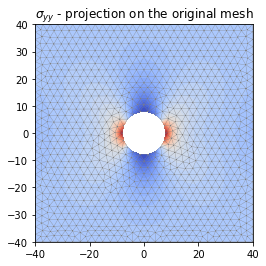

In [99]:
plot(fe_sigma_yy_unsplited_scaled, title=r'$\sigma_{yy}$' + " - projection on the original mesh", wireframe=False, cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('syy_2.pdf', bbox_inches = 'tight')

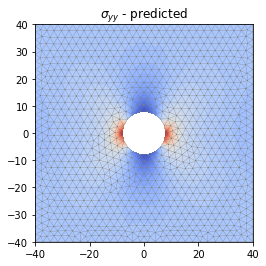

In [100]:
plot(fe_sigma_yy_predicted_unsplited_scaled, title=r'$\sigma_{yy}$' + " - predicted", cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('syy_p.pdf', bbox_inches = 'tight')

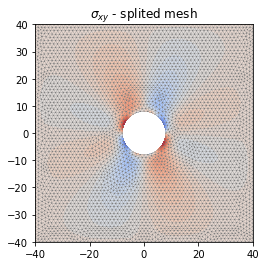

In [101]:
plot(fe_sigma_xy_scaled, title=r'$\sigma_{xy}$' + " - splited mesh", cmap=cm.coolwarm)
plot(mesh, linewidth=0.3)
plt.savefig('sxy_1.pdf', bbox_inches = 'tight')

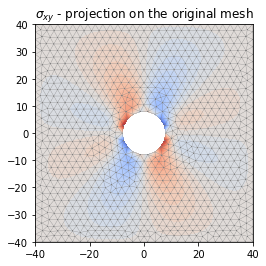

In [110]:
plot(fe_sigma_xy_unsplited_scaled, title=r'$\sigma_{xy}$' + " - projection on the original mesh", cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('sxy_2.pdf', bbox_inches = 'tight')

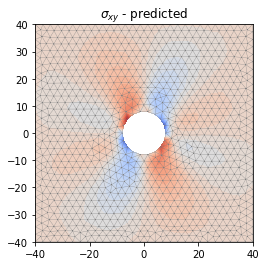

In [111]:
plot(fe_sigma_xy_predicted_unsplited_scaled, title=r'$\sigma_{xy}$' + " - predicted", cmap=cm.coolwarm)
plot(mesh_unsplited, linewidth=0.3)
plt.savefig('sxy_p.pdf', bbox_inches = 'tight')

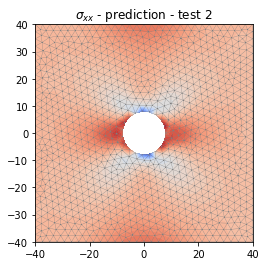

In [104]:
plot(fe_sigma_xx_predicted_test_2_scaled, title=r'$\sigma_{xx}$' + " - prediction - test 2", cmap=cm.coolwarm)
plot(mesh_test_2, linewidth=0.3)
plt.savefig('sxx_p_test_2.pdf', bbox_inches = 'tight')

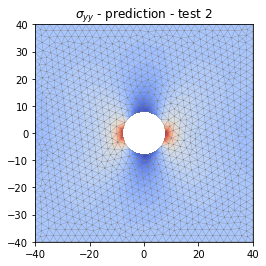

In [105]:
plot(fe_sigma_yy_predicted_test_2_scaled, title=r'$\sigma_{yy}$' + " - prediction - test 2", cmap=cm.coolwarm)
plot(mesh_test_2, linewidth=0.3)
plt.savefig('syy_p_test_2.pdf', bbox_inches = 'tight')

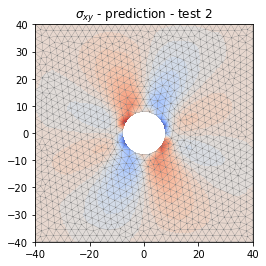

In [106]:
plot(fe_sigma_xy_predicted_test_2_scaled, title=r'$\sigma_{xy}$' + " - prediction - test 2", cmap=cm.coolwarm)
plot(mesh_test_2, linewidth=0.3)
plt.savefig('sxy_p_test_2.pdf', bbox_inches = 'tight')

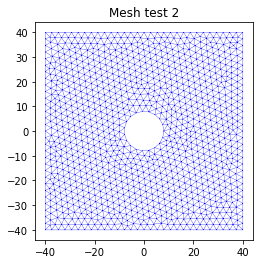

In [11]:
plot(mesh_test_2, linewidth=0.3, color='blue', title="Mesh test 2")
plt.savefig('mesh_test_2.pdf', bbox_inches = 'tight')

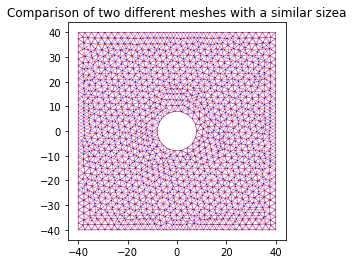

In [13]:
plot(mesh_test_2, linewidth=0.3, color='blue', title="Comparison of two different meshes with a similar sizeа")
plot(mesh_unsplited, linewidth=0.3, color='red')
plt.savefig('meshes_tests.pdf', bbox_inches = 'tight')

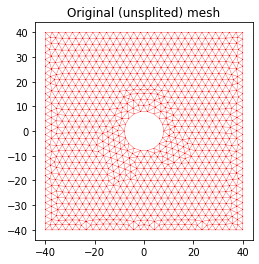

In [12]:
plot(mesh_unsplited, linewidth=0.3, color='red', title="Original (unsplited) mesh")
plt.savefig('mesh_unsplited.pdf', bbox_inches = 'tight')

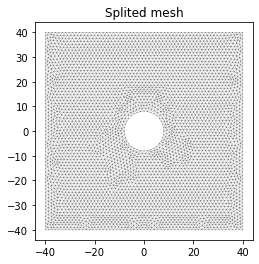

In [109]:
plot(mesh, linewidth=0.3, title="Splited mesh")
plt.savefig('mesh_splited.pdf', bbox_inches = 'tight')

## Подход №2. Сверточный нейронные сети

In [49]:
from math import gcd

def factorization(n):

    factors = []

    def get_factor(n):
        x_fixed = 2
        cycle_size = 2
        x = 2
        factor = 1

        while factor == 1:
            for count in range(cycle_size):
                if factor > 1: break
                x = (x * x + 1) % n
                factor = gcd(x - x_fixed, n)

            cycle_size *= 2
            x_fixed = x

        return factor

    while n > 1:
        next = get_factor(n)
        factors.append(next)
        n //= next
    
    factors.sort()

    return factors

def get_two_factors(factors):
    fact2 = factors.pop(-1)
    fact1 = factors.pop(-1)
    # factors.remove(fact1)
    # fact2 = 1
    for f in factors:
        if fact2 > fact1:
            fact1 *= f
        else:
            fact2 *= f 

    return [fact1, fact2]

In [57]:
factors = factorization(x_train.shape[0])
Nx, Ny = get_two_factors(factors)

54

In [63]:
factors = factorization(x_train.shape[0])
N_train, M_train = get_two_factors(factors)

x_conv_train_scaled = x_train_scaled.reshape(N_train, M_train)
y_conv_train_scaled = y_train_scaled.reshape(N_train, M_train)
sXX_conv_train_scaled = sXX_train_scaled.reshape(N_train, M_train)


In [83]:
R = 8
L = 10*R
L_diag = sqrt(2.0)*L - 2*R
l = 2 * np.pi * R  / 4
N_circ = 5
d = l / (N_circ - 1)
N_diag = L_diag / d + 1
N = L / d + 1
print(L,L_diag, l, d, N_diag, N)

80 97.13708498984761 12.566370614359172 3.141592653589793 31.919694467343593 26.464790894703256


In [ ]:
input_xy = Input(shape = (2,))
layer = Dense(units = 8, activation='relu')(input_xy)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
layer = Dense(units = 128, activation='relu')(layer)
layer = Dense(units = 64, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 32, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 16, activation='relu')(layer)
layer = Dense(units = 8, activation='relu')(layer)

output_stresses = Dense(units=3, activation='relu')(layer)

model_input_2_output_3 = Model(input_xy, output_stresses)
model_input_2_output_3.summary()
model_input_2_output_3.compile(optimizer = "adam", loss='mean_absolute_error')

In [91]:
inp = Input(shape=(2))
layer = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(inp)
layer = MaxPool1D(pool_size=2)(layer)
layer = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(layer)
layer = MaxPool1D(pool_size=2)(layer)
layer = Conv1D(filters=16, kernel_size=2, padding='same', activation='relu')(layer)
layer = MaxPool1D(pool_size=2)(layer)
layer = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(layer)
layer = MaxPool1D(pool_size=2)(layer)
layer = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(layer)
layer = MaxPool1D(pool_size=2)(layer)

layer = Flatten()(layer)
layer = Dense(units=128)(layer)
out = Dense(units=3, activation='relu')(layer)

model_conv1D = Model(inp, out)

model_conv1D.summary()

model_conv1D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], )

ValueError: Input 0 of layer conv1d_2 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 2)

## Errors calculations 

In [114]:
abs_error_C_sxx = np.max(np.abs(sXX_predict_scaled - sXX_test_scaled)) / np.max(np.abs(sXX_test_scaled))
abs_error_C_syy = np.max(np.abs(sYY_predict_scaled - sYY_test_scaled)) / np.max(np.abs(sYY_test_scaled))
abs_error_C_sxy = np.max(np.abs(sXY_predict_scaled - sXY_test_scaled)) / np.max(np.abs(sXY_test_scaled))

error_L2_sxx = errornorm(fe_sigma_xx_unsplited_scaled, fe_sigma_xx_predicted_unsplited_scaled, 'L2')
error_L2_syy = errornorm(fe_sigma_yy_unsplited_scaled, fe_sigma_yy_predicted_unsplited_scaled, 'L2')
error_L2_sxy = errornorm(fe_sigma_xy_unsplited_scaled, fe_sigma_xy_predicted_unsplited_scaled, 'L2')
L2_norm_fe_sigma_xx = norm(fe_sigma_xx_unsplited_scaled, 'L2')
L2_norm_fe_sigma_yy = norm(fe_sigma_yy_unsplited_scaled, 'L2')
L2_norm_fe_sigma_xy = norm(fe_sigma_xy_unsplited_scaled, 'L2')

print('sigmaxx \t sigma yy \t sigma xy')
print('C, %: ', round(abs_error_C_sxx*100,2), round(abs_error_C_syy*100,2), round(abs_error_C_sxy*100,2))
print('L2, %: ', round(error_L2_sxx/L2_norm_fe_sigma_xx*100, 2), round(error_L2_syy/L2_norm_fe_sigma_yy*100, 2), round(error_L2_sxy/L2_norm_fe_sigma_xy*100, 2))

sigmaxx 	 sigma yy 	 sigma xy
C, %:  20.72 18.03 25.73
L2, %:  1.22 1.83 1.94


In [115]:
# sXX_predict_test_2_scaled

abs_error_C_sxx = np.max(np.abs(sXX_predict_test_2_scaled - sXX_test_2_scaled)) / np.max(np.abs(sXX_test_2_scaled))
abs_error_C_syy = np.max(np.abs(sYY_predict_test_2_scaled - sYY_test_2_scaled)) / np.max(np.abs(sYY_test_2_scaled))
abs_error_C_sxy = np.max(np.abs(sXY_predict_test_2_scaled - sXY_test_2_scaled)) / np.max(np.abs(sXY_test_2_scaled))

error_L2_sxx = errornorm(fe_sigma_xx_test_2_scaled, fe_sigma_xx_predicted_test_2_scaled, 'L2')
error_L2_syy = errornorm(fe_sigma_yy_test_2_scaled, fe_sigma_yy_predicted_test_2_scaled, 'L2')
error_L2_sxy = errornorm(fe_sigma_xy_test_2_scaled, fe_sigma_xy_predicted_test_2_scaled, 'L2')
L2_norm_fe_sigma_xx = norm(fe_sigma_xx_test_2_scaled, 'L2')
L2_norm_fe_sigma_yy = norm(fe_sigma_yy_test_2_scaled, 'L2')
L2_norm_fe_sigma_xy = norm(fe_sigma_xy_test_2_scaled, 'L2')

print('sigmaxx \t sigma yy \t sigma xy')
print('C, %: ', round(abs_error_C_sxx*100,2), round(abs_error_C_syy*100,2), round(abs_error_C_sxy*100,2))
print('L2, %: ', round(error_L2_sxx/L2_norm_fe_sigma_xx*100, 2), round(error_L2_syy/L2_norm_fe_sigma_yy*100, 2), round(error_L2_sxy/L2_norm_fe_sigma_xy*100, 2))

sigmaxx 	 sigma yy 	 sigma xy
C, %:  24.48 17.69 25.48
L2, %:  2.71 3.41 2.04


In [59]:
help(errornorm)

Help on function errornorm in module dolfin.fem.norms:

errornorm(u, uh, norm_type='l2', degree_rise=3, mesh=None)
    Compute and return the error :math:`e = u - u_h` in the given norm.
    
    *Arguments*
        u, uh
            :py:class:`Functions <dolfin.functions.function.Function>`
        norm_type
            Type of norm. The :math:`L^2` -norm is default.
            For other norms, see :py:func:`norm <dolfin.fem.norms.norm>`.
        degree_rise
            The number of degrees above that of u_h used in the
            interpolation; i.e. the degree of piecewise polynomials used
            to approximate :math:`u` and :math:`u_h` will be the degree
            of :math:`u_h` + degree_raise.
        mesh
            Optional :py:class:`Mesh <dolfin.cpp.Mesh>` on
            which to compute the error norm.
    
    In simple cases, one may just define
    
    .. code-block:: python
    
        e = u - uh
    
    and evalute for example the square of the error in the 

In [68]:
help(norm)


Help on function norm in module dolfin.fem.norms:

norm(v, norm_type='L2', mesh=None)
    Return the norm of a given vector or function.
    
    *Arguments*
        v
            a :py:class:`Vector <dolfin.cpp.Vector>` or
            a :py:class:`Function <dolfin.functions.function.Function>`.
        norm_type
            see below for alternatives.
        mesh
            optional :py:class:`Mesh <dolfin.cpp.Mesh>` on
            which to compute the norm.
    
    If the norm type is not specified, the standard :math:`L^2` -norm
    is computed. Possible norm types include:
    
    *Vectors*
    
    ================   =================  ================
    Norm               Usage
    ================   =================  ================
    :math:`l^2`        norm(x, 'l2')      Default
    :math:`l^1`        norm(x, 'l1')
    :math:`l^\infty`   norm(x, 'linf')
    ================   =================  ================
    
    *Functions*
    
    ================  =========

In [96]:
help(plot)

Help on function plot in module dolfin.common.plotting:

plot(object, *args, **kwargs)
    Plot given object.
    
    *Arguments*
        object
            a :py:class:`Mesh <dolfin.cpp.Mesh>`, a :py:class:`MeshFunction
            <dolfin.cpp.MeshFunction>`, a :py:class:`Function
            <dolfin.functions.function.Function>`, a :py:class:`Expression`
            <dolfin.cpp.Expression>, a :py:class:`DirichletBC`
            <dolfin.cpp.DirichletBC>, a :py:class:`FiniteElement
            <ufl.FiniteElement>`.
    
    *Examples of usage*
        In the simplest case, to plot only e.g. a mesh, simply use
    
        .. code-block:: python
    
            mesh = UnitSquare(4, 4)
            plot(mesh)
    
        Use the ``title`` argument to specify title of the plot
    
        .. code-block:: python
    
            plot(mesh, tite="Finite element mesh")
    
        It is also possible to plot an element
    
        .. code-block:: python
    
            element = Finite